# DEA Land Cover change mapping <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/ga_ls_landcover_class_cyear_2)


## Background 

Land cover is the observed physical cover on the Earth's surface. 
Land cover changes for many reasons, including seasonal weather, severe weather events such as cyclones, floods and fires, and human activities such as mining, agriculture and urbanisation. 
We can use change mapping techniques to quantify how these processes influence land cover. 

## Description 

This notebook will demonstrate how to create a change map using [DEA Land Cover](https://cmi.ga.gov.au/data-products/dea/607/dea-land-cover-landsat) data. 
Topics include: 

1. Loading data for an area of interest.
2. Plotting a change map using Level 3 data. 
3. Plotting a change map using layer descriptor data. 

This notebook requires a basic understanding of the DEA Land Cover data set. 
If you are new to DEA Land Cover, it is recommended you look at the [DEA Land Cover beginners notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

## Getting started

To run this analysis, run all the cells in the notebook starting with the 'Load packages and connect to the datacube' cell.

### Load packages and connect to the datacube

Load key Python packages and supporting functions for the analysis, then connect to the datacube. 

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import sys, os
sys.path.insert(1, os.path.abspath('../../Tools'))
from dea_tools.plotting import rgb
from dea_tools.plotting import rgb, display_map
from matplotlib import colors as mcolours
from dea_tools.land_cover import plot_land_cover, lc_colourmap

In [2]:
dc = datacube.Datacube(app="DEA_Land_Cover")

## Select and view your study area

**If running the notebook for the first time,** keep the default settings below.
This will demonstrate how the change mapping functionality works and provide meaningful results.
The following example loads land cover data over Werribee, Victoria.

In [3]:
# Define area of interest and buffer values
lat, lon = (-37.9, 144.7)

lat_buffer = 0.02
lon_buffer = 0.02

# Combine central coordinates with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Set the range of dates for the analysis
time_range = ("2010", "2020")

The following cell will display the area of interest on an interactive map. 
You can zoom in and out to better understand the area you'll be analysing. 

In [4]:
display_map(x=lon_range, y=lat_range)

## Load and view `level3` data 
The following cell will load `level3` data for the `lat_range`, `lon_range` and `time_range` we defined above.

In [5]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes and time defined above
query = {
    "y": lat_range,
    "x": lon_range,
    "time": time_range,
}

# Load DEA Land Cover data from the datacube
lc = dc.load(
    product="ga_ls_landcover_class_cyear_2",
    output_crs="EPSG:3577",
    measurements=["level3"],
    resolution=(-25, 25),
    **query
)

We can review the data by using the `plot_land_cover()` function.

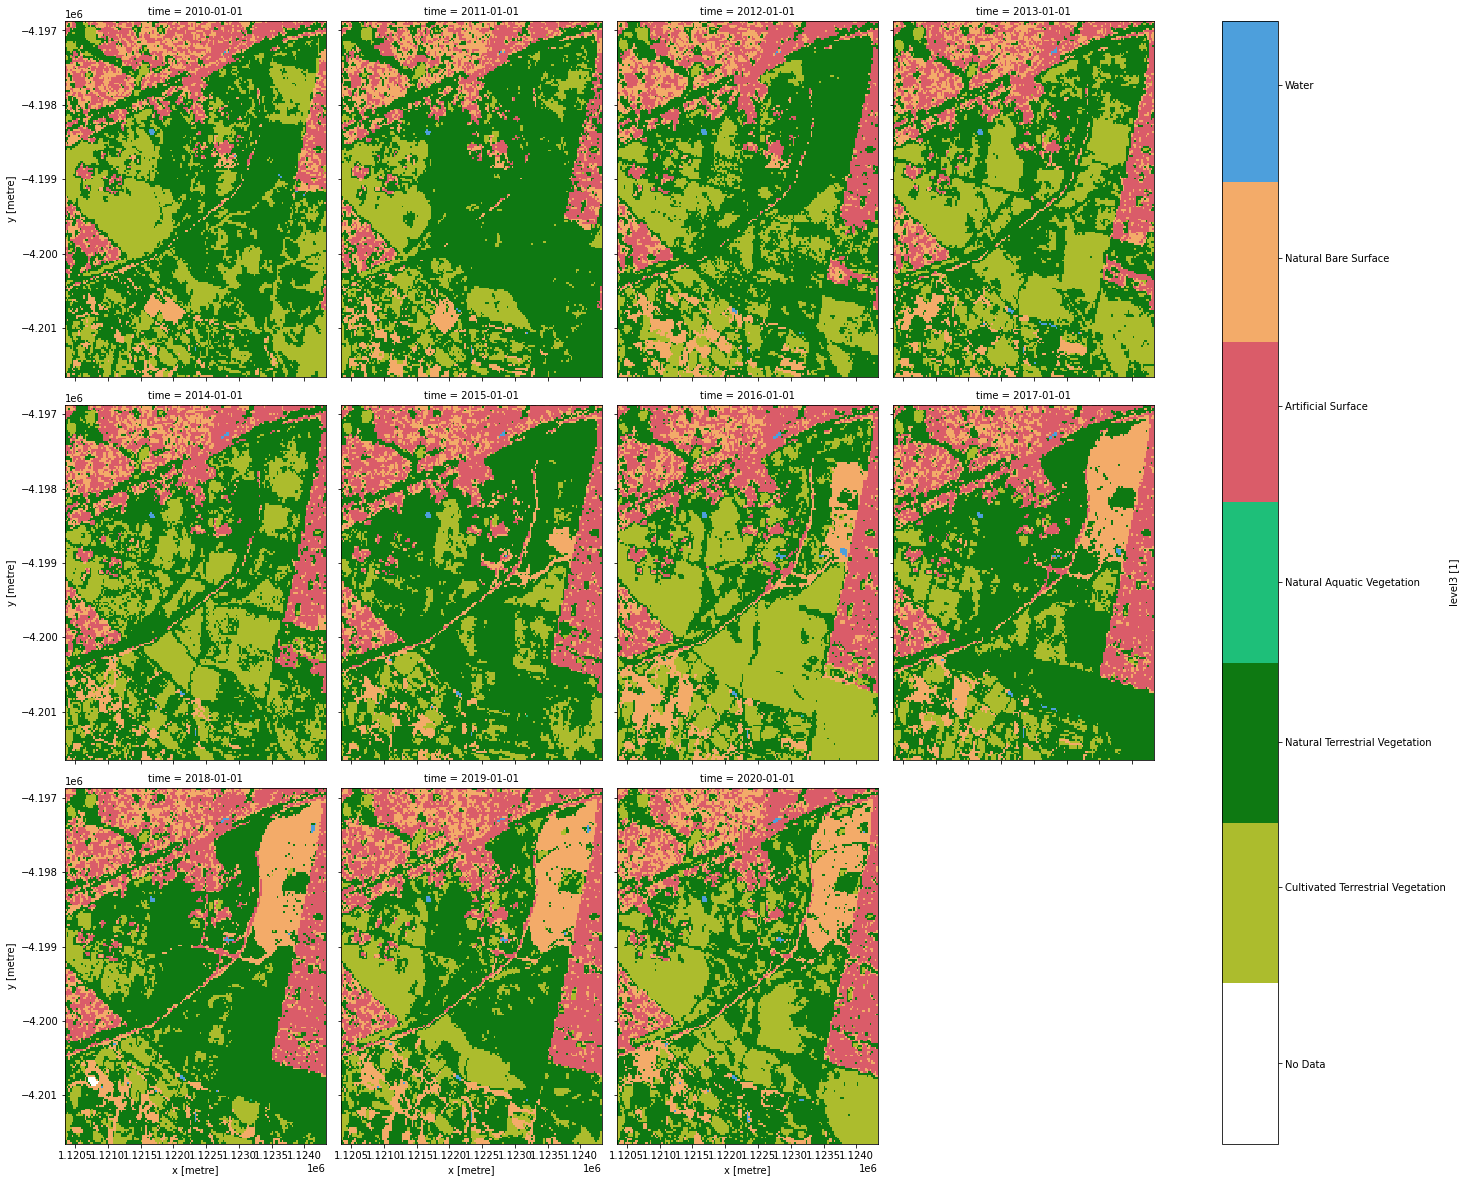

In [6]:
plot_land_cover(lc.level3)

## Plotting change maps

### Level 3 change maps 

In this section, we will create a plot that shows if a pixel changed class or remained the same between 2 discrete years. 
In this example, we are using 2010 and 2020.

In [7]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[0].astype(np.int32)
end = lc.level3[-1].astype(np.int32)

# Mark if you want to ignore no change
ignore_no_change = True

In [8]:
# Combine classifications from start and end dates
change_vals = (start * 1000) + end

# Mask out values with no change by setting to 0 if this is requested
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)

In [9]:
level_3 = lc.level3[0].drop_vars("time")

In [10]:
# Create a new Xarray.DataArray
change = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [11]:
# Set colour map, normalisation and labels for colour bar
cb_cmap, cb_norm, cb_labels, cb_ticks = lc_colourmap(
    "level3_change_colour_bar", colour_bar=True
)

cb_data = [[0, 111, 112, 215, 216, 220]]

In [12]:
# Use load from file colour map fuction
cmap_2, norm_2 = lc_colourmap("level3_change_colour_scheme")

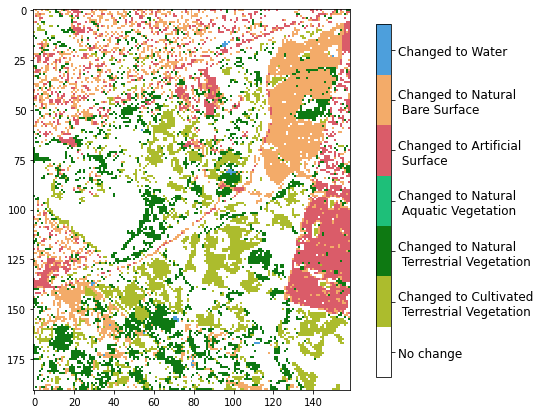

In [13]:
# Create figure with subplot and set size in inches
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)

# Add colour bar
fig.subplots_adjust(right=0.825)
cax = fig.add_axes([0.84, 0.15, 0.03, 0.70])

# Generate colour bar with colour bar data (not change data)
img = ax.imshow(cb_data, cmap=cb_cmap, norm=cb_norm)
cb = fig.colorbar(
    img,
    cax=cax,
)

# Plot change data
img = ax.imshow(change, cmap=cmap_2, norm=norm_2, interpolation="nearest")

# Adjust colour bar label settings
tick_font_size = 12
cb.ax.tick_params(labelsize=tick_font_size)
ticks = cb.get_ticks()
cb.set_ticks(ticks + np.diff(ticks, append=221) / 2)
cb.set_ticklabels(cb_labels)

### Layer descriptor change maps 

In this section, we will plot two change maps using natural terrestrial vegetation (NTV) data and artificial surface (AS) data. 
Similar to above, we will use 2010 and 2020 data. 

#### Natural terrestrial vegetation change

In [14]:
# Make a mask of 1 for all increasing NTV that is anything going from another class to NTV
NTV_increase = np.where(
    (
        (change == 111112)
        | (change == 124112)
        | (change == 215112)
        | (change == 216112)
        | (change == 220112)
    ),
    1,
    0,
)

In [15]:
# Make a mask of -1 for all decreasing NTV that is anything going from NTV to another class
NTV_decrease = np.where(
    (
        (change == 112111)
        | (change == 112124)
        | (change == 112215)
        | (change == 112216)
        | (change == 112220)
    ),
    -1,
    0,
)

In [16]:
NTV_change = NTV_increase + NTV_decrease

In [17]:
# Create a new Xarray.DataArray
xr_ntvchange = xr.DataArray(
    data=NTV_change,
    coords=change.coords,
    dims=change.dims,
    name="ntv_change",
    attrs=None,
    indexes=change.indexes,
    fastpath=False,
)

The next cell plots the NTV change map, where red represents NTV loss and blue represents NTV gain.

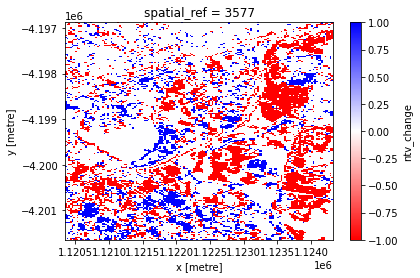

In [18]:
xr_ntvchange.plot.imshow(cmap="bwr_r")

#### Urban expansion

In [19]:
# Make a mask of 1 for all areas which became AS
AS_increase = np.where(
    (
        (change == 111215)
        | (change == 112215)
        | (change == 124215)
        | (change == 216215)
        | (change == 220215)
    ),
    1,
    0,
)

In [20]:
# Make a mask of -1 for all areas which changed from being AS to something else
AS_decrease = np.where(
    (
        (change == 215111)
        | (change == 215112)
        | (change == 215124)
        | (change == 215216)
        | (change == 215220)
    ),
    -1,
    0,
)

In [21]:
AS_change = AS_increase + AS_decrease

In [22]:
# Create a new Xarray.DataArray
xr_aschange = xr.DataArray(
    data=AS_change,
    coords=change.coords,
    dims=change.dims,
    name="as_change",
    attrs=None,
    indexes=change.indexes,
    fastpath=False,
)

The next cell plots the artificial surface change map, where blue represents artificial surface loss and pink represents artificial surface gain.

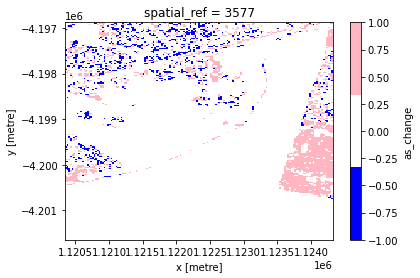

In [23]:
cmap = mcolours.ListedColormap(["b", "white", "lightpink"])
xr_aschange.plot.imshow(cmap=cmap)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2021

**Compatible datacube version:** 

In [24]:
print(datacube.__version__)

1.8.6


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)